In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product
import scipy
import pyclustering
from pyclustering.cluster.kmeans import kmeans as pyKMeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

import clustering_utils

In [2]:
df_weather = pd.read_csv('data/weather.csv', index_col=0)
df_region_ids = pd.read_csv('data/regions.csv')

In [3]:
df_weather.head()

,date,weather,weather_l,region_ids,region_names,conditions_ids,conditions
0,2019-04-07 11:45:00,8 апреля в горах Дагестана выше 2500 м в гора...,8 апрель в гора дагестан высоко 2500 м в гора ...,"[43, 46]","['Республика Алтай', 'Республика Дагестан']",[6],['лавины']
1,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],['Республика Коми'],[],[]
2,2019-04-06 10:55:00,7-9 апреля в горных районах муниципального обр...,7 - 9 апрель в горный район муниципальный обра...,[22],['Краснодарский край'],[6],['лавины']
3,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],['Республика Коми'],[],[]
4,2019-04-06 09:30:00,7 апреля в горах Дагестана выше 2500 м 7-9 ...,7 апрель в гора дагестан высоко 2500 м 7 - 9 а...,"[42, 77, 46, 47, 22]","['Республика Адыгея', 'Чеченская Республика', ...",[6],['лавины']


In [4]:
from ast import literal_eval

In [5]:
df_weather = df_weather[['date', 'region_ids', 'conditions_ids']]
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['region_ids'] = df_weather['region_ids'].apply(literal_eval)
df_weather['conditions_ids'] = df_weather['conditions_ids'].apply(literal_eval)
df_weather.head()

,date,region_ids,conditions_ids
0,2019-04-07 11:45:00,"[43, 46]",[6]
1,2024-02-12 15:18:00,[50],[]
2,2019-04-06 10:55:00,[22],[6]
3,2024-02-12 15:18:00,[50],[]
4,2019-04-06 09:30:00,"[42, 77, 46, 47, 22]",[6]


In [6]:
df_weather = df_weather[df_weather['conditions_ids'].apply(lambda x : len(x) > 0)]

In [7]:
df_weather.head()

,date,region_ids,conditions_ids
0,2019-04-07 11:45:00,"[43, 46]",[6]
2,2019-04-06 10:55:00,[22],[6]
4,2019-04-06 09:30:00,"[42, 77, 46, 47, 22]",[6]
5,2024-02-12 14:25:00,[61],"[10, 5]"
6,2019-04-05 13:03:00,[22],[7]


In [8]:
df_weather['month'] = df_weather['date'].dt.month - 1
df_weather.drop('date', axis=1, inplace=True)
df_weather.head()

,region_ids,conditions_ids,month
0,"[43, 46]",[6],3
2,[22],[6],3
4,"[42, 77, 46, 47, 22]",[6],3
5,[61],"[10, 5]",1
6,[22],[7],3


In [9]:
df_weather = df_weather.explode('region_ids', ignore_index=True)
df_weather = df_weather.explode('conditions_ids', ignore_index=True)

In [10]:
print(len(df_weather))
df_weather.dropna(inplace=True)
print(len(df_weather))
df_weather.head()

38264
37930


,region_ids,conditions_ids,month
0,43,6,3
1,46,6,3
2,22,6,3
3,42,6,3
4,77,6,3


In [11]:
weather_ids = pd.read_csv('data/weather_ids.csv', index_col=0, header=None, squeeze=True);
weather_ids.head()

/tmp/ipykernel_508451/4162231500.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  weather_ids = pd.read_csv('data/weather_ids.csv', index_col=0, header=None, squeeze=True);


0
1                       ветер
2                дожди, ливни
3                       гроза
4                        град
5    снегопад, снежный покров
Name: 1, dtype: object

In [12]:
region_ids = sorted(df_weather['region_ids'].unique())

In [13]:
per_month_clusters = {r : {m : 0 for m in range(12)} for r in region_ids}

In [14]:
for m in range(12) :
    # Филтр по месяцу
    df_weather_m = df_weather[df_weather['month'] == m][['region_ids', 'conditions_ids']]

    # Частоты погодных явлений для каждого района по фиксированному месяцу
    regions_dict_m = {r : {s : 0 for s in weather_ids.index} for r in region_ids}
    for index, row in df_weather_m.iterrows() :
        s = row['conditions_ids']
        regions_dict_m[row['region_ids']][s] += 1

    X = pd.DataFrame.from_dict(regions_dict_m, orient='index')
    clusters = KMeans(n_clusters=2, init='k-means++', max_iter=10000, random_state=5, n_init='auto').fit(preprocessing.normalize(X, axis=0))
    #clusters = DBSCAN().fit(preprocessing.normalize(X, axis=0))


    i = 0
    for r in region_ids :
        per_month_clusters[r][m] = clusters.labels_[i]
        i += 1

In [15]:
df_weather_pm = pd.DataFrame.from_dict(per_month_clusters, orient='index')

In [16]:
d_mean = np.zeros(12)
for j in range(12) :
    d_temp = 0
    for i1, i2 in product(region_ids, region_ids) :
        d_temp += int(df_weather_pm.iloc[i1, j] == df_weather_pm.iloc[i2, j])
    d_mean[j] = (d_temp + 0.01) / len(region_ids)**2

In [17]:
M = len(d_mean)
w = np.array([(1 / M) / d for d in d_mean])
w /= np.linalg.norm(w)
w

array([0.27208261, 0.27208261, 0.30676345, 0.25908491, 0.30676345,
       0.33622768, 0.37375846, 0.25908491, 0.2527917 , 0.2466389 ,
       0.24062802, 0.30676345])

In [18]:
weights = w

In [19]:
weightened_hamming_distance = lambda x, y : scipy.spatial.distance.hamming(x, y)

In [20]:
hamming_distance = lambda x, y : scipy.spatial.distance.hamming(x, y)

In [21]:
custom_distance = weightened_hamming_distance

In [22]:
X = df_weather_pm.copy()

In [23]:
import warnings
np.warnings = warnings

In [24]:
distance_matrix = np.zeros((len(region_ids), len(region_ids)))

In [25]:
for i1, i2 in product(range(len(region_ids)), range(len(region_ids))) :
    distance_matrix[i1, i2] = distance_matrix[i2, i1] = custom_distance(X.iloc[i1], X.iloc[i2])

In [26]:
import kmedoids

In [27]:
def KMedoids(dist_matrix, custom_distance, n_clusters=2) :
    kmedoids_instance = kmedoids.KMedoids(n_clusters=n_clusters, method='fasterpam')
    kmedoids_instance.fit(dist_matrix)
    return (kmedoids_instance.labels_, kmedoids_instance.inertia_)

In [28]:

def silhouette_criteria(X, clustering_func, distance_matrix) :
    silhouettes = []
    for i in range(2, 15) :
        #kmeans = KMeans(n_clusters=i, n_init='auto').fit(X)
        kmeans = clustering_func(distance_matrix, custom_distance, n_clusters=i)
        label = kmeans[0]
        silhouettes.append(silhouette_score(X, label, metric=custom_distance))
    plt.xticks([i for i in range(2, 15)])
    plt.plot([i for i in range(2, 15)], silhouettes)

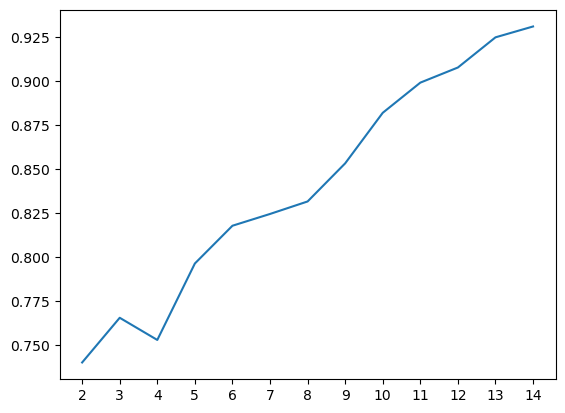

In [29]:
silhouette_criteria(X, KMedoids, distance_matrix)

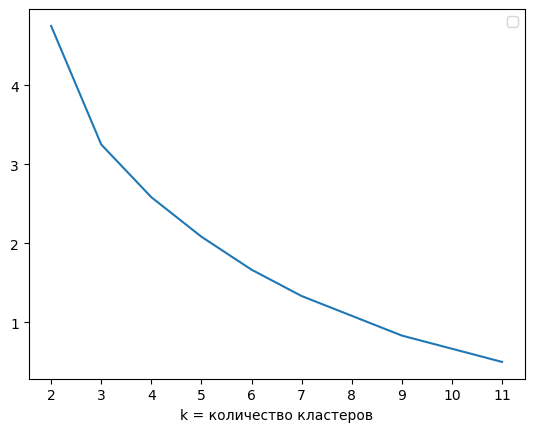

In [30]:
clustering_utils.elbow_criteria(distance_matrix, KMedoids, np.nan)

In [37]:
kmeans = clustering_utils.KMedoids(distance_matrix, custom_distance, 4)

[65 68 27 21]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 0, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3]


In [38]:
df_regions_clustered = df_weather_pm.copy()
df_regions_clustered['cluster_id'] = kmeans[0]
df_regions_clustered['region_name'] = df_region_ids['region']
# for i in range(len(df_regions1)) :
#     df_regions1['region_name'][i] = df_region_ids[i]
df_regions_clustered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,cluster_id,region_name
0,0,0,1,0,0,0,0,0,0,0,0,1,3,Алтайский край
1,0,0,0,0,0,0,0,0,0,0,0,0,3,Амурская область
2,0,0,0,0,0,0,0,0,0,0,0,0,3,Архангельская область
3,0,0,0,0,0,0,0,0,0,0,0,0,3,Астраханская область
4,0,0,0,0,0,0,0,0,0,0,0,0,3,Белгородская область


In [39]:
df_regions_clustered.to_csv('region2.csv')

In [40]:
silhouette_score(X, kmeans[0], metric=custom_distance)

0.7752051955916576

In [41]:
dbscan = DBSCAN(metric=custom_distance).fit(X)

In [42]:
silhouette_score(X, dbscan.labels_, metric=custom_distance)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
(dbscan.labels_)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
#df_regions_clustered['cluster_id'] = dbscan.labels_
#df_regions_clustered.to_csv('region2.csv')